# Using frank as a library: The fitting procedure in detail

To give further insight into the fitting process in <font color=green>Frankenstein</font> (`frank`) and how you can modify it, here we'll use the code as a library and perform the same fit process in the [Quickstart](quickstart.rst), just in more detail.

We'll keep the DSHARP continuum observations of AS 209 ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)) as the input dataset, and frank will reconstruct the disc's 1D radial brightness profile by nonparametrically fitting the real component of the visibility distribution. 

Specifically frank will perform 4 steps in the fit, which we'll break into distinct calls (these are the steps taken in `fit.py`): 

1. Read in the data (UVTable) and parse the *.json* parameter file; 

2. Determine the disc geometry (inclination, position angle and phase offset), then deproject the visibilities;

3. Fit the deprojected visibilities with a Gaussian process (~10 s) to yield a brightness profile;

4. Save the results: the brightness profile fit, visibility domain fit, UVtables with the **reprojected** fit and residuals between the input datafile and the reprojected fit, and a figure showing the fit and diagnostics. We'll also supply a CLEAN brightness profile for the disc as well as the synthesized CLEAN beam parameters, allowing frank to compare his fit to the CLEAN fit by:

    - Convolving the fitted frank brightness profile with the synthesized beam to compare to the CLEAN profile and
    
    - Taking the discrete Hankel transform of the CLEAN profile to compare to the frank visibility domain fit.
    
Let's walk through these.

## 1. Read in the data and parameter values

First import the goods. As in the library example in the [Quickstart](quickstart.rst), we're importing the internal classes [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) and [FitGeometryGaussian](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FitGeometryGaussian) directly in order to demonstrate their usage. Just note that `fit.py` uses the wrapper functions `deproject_disc` and `perform_fit` to call these.

In [2]:
%matplotlib inline

from frankenstein.constants import rad_to_arcsec
from frankenstein.radial_fitters import FrankFitter
from frankenstein.geometry import FitGeometryGaussian
from frankenstein.fit import parse_parameters, load_uvdata, output_results

SyntaxError: invalid syntax (fit.py, line 54)

Using a UVTable extracted from an MSTable (see [xx](xx.xx) for how to do this) and the default parameter file `default_parameters.json`, we read both in.

In [ ]:
args, model = parse_parameters(parameter_file)

## 2. Determinine the disc geometry and deproject the visibilities

Before fitting the radial brightness profile, we need to determine the disc's geometry (inclination, position angle and phase center) in order to deproject the visibilities (frank, fitting in 1D, assumes an axisymmetric source).
To do this we pass an object specifying how the geometry is determined to the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class.

frank has two classes for this: [FixedGeometry](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FixedGeometry) just takes a geometry you provide, while [FitGeometryGaussian](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FitGeometryGaussian) determines the geometry by fitting a 2D Gaussian directly to the visibilities. For the latter you can also choose to provide a known phase center if you just want to fit for the inclination and PA.

### Adding your own geometry fit routine

You can extend frank's geometry fitting capabilities with your own routines by writing a class that inherits from the [SourceGeometry](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry) base class. This base class provides the interface used by frank to deproject the visibilities, but you do need to implement your own [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.fit) method. This method will be called internally by [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) to determine the geometry.

The [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.fit) method should set the attributes `_inc`,  `_PA`, `_dRA`, and `_dDec`, which are used by the
[apply_correction()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.apply_correction),
[undo_correction()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.undo_correction),
[deproject()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.deproject),
and
[reproject()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.reproject) methods.

## 3. Fit the deprojected visibilities for the brightness profile

Objects used to perform a fit are in the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class. The main parameters are: `Rmax` and `N`, controlling the disc radius out to which the fit is performed and the number of collocation points used in the fit; and the `geometry` object detailed [above](using_frank_as_library.ipynb#2.-Determinine-the-disc-geometry-and-deproject-the-data). The hyperprior is controlled through the parameters `alpha`, `p_0` and `smooth`.

frank performs a fit with the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class' [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter.fit) function.

## 4. Save the results and generate plots

Once the fit is complete the best fit parameters are returned and stored in the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class' [MAP_solution](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter.MAP_solution) attribute. 
The fit is returned as a [_HankelRegressor](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor) object, which provides the posterior [mean](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.mean), [covariance](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.covariance), and [power_spectrum](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.power_spectrum), as well as the fit's radius points [r](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.r) and corresponding frequency points [q](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.q). 

The solution object also provides methods to compute the best fit model's visibilities with [predict](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.predict) and to evaluate its [log_likelihood](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.log_likelihood).

A simple figure showing the fitted brightness profile, fitted visibility distribution and power spectrum reconstruction,

We could also use [CASA](https://casa.nrao.edu) to CLEAN (thereby convolving with the synthesized beam) the `frank` fit image to compare with the CLEAN model image.

In [2]:
# Enables plotting of negative data on a log-scale
def plot_log_abs(x, y, **kwargs):
    c = plt.loglog(x, y, **kwargs)[0].get_color()
    
    kwargs = dict(kwargs) 
    kwargs['c'] = c
    kwargs['label'] = None
    plt.loglog(x, -y, ls='--', **kwargs)

def bin_uv_data(baselines, vis, weights, Nbins=512, recompute_weights=True):
    """
    Group the uv-data into bins.
    
    Parameters
    ----------
    baslines : 1D array,
        uv points (i.e. np.hypot(u,v))
    vis : 1D array,
        Visibility data
    weights : 1D array,
        Weights on the visibility data
    Nbins : int, default = 512
        Number of equally spaced in log bins to use.
    recompute_weights : bool, default = True
        If true, the weights will be recomputed for the number of points
        and variance in each bin. Otherwise the weight will be the sum of
        the weights for the points in each bin.
    
    Returns
    -------
    kbins : 1D array
        Centre of each uv-bin.
    bin_obs : 1D array
        Binned visibilites.
    bin_weights : 1D array,
        Binned weights.
        
    """
    log_lam = np.log(baselines)

    cnt, edges = np.histogram(log_lam, bins=Nbins)
    bin_wgt, _ = np.histogram(log_lam, bins=Nbins, weights=weights)
    bin_obs, _ = np.histogram(log_lam, bins=Nbins, weights=weights*vis)
    bin_ob2, _ = np.histogram(log_lam, bins=Nbins, weights=weights*vis**2)
    bin_lam, _ = np.histogram(log_lam, bins=Nbins, weights=weights*baselines)

    idx = cnt > 0
    bin_obs[idx] /= bin_wgt[idx]
    bin_ob2[idx] /= bin_wgt[idx]
    bin_lam[idx] /= bin_wgt[idx]

    if recompute_weights:
        idx = cnt > 1
        bin_wgt[idx] = (cnt[idx]-1) / (bin_ob2[idx] - bin_obs[idx]**2)

    # Clear empty bins
    idx = bin_wgt > 0
    bin_lam, bin_obs, bin_wgt = map(lambda x: x[idx], [bin_lam, bin_obs, bin_wgt])
        
    return bin_lam, bin_obs, bin_wgt

In [3]:
uv_AS209_DHSARP = np.load('AS209_continuum.npz')

Load the radial profile. We store it in an object for convenience

Text(0.5,1,'CLEAN profile for AS 209')

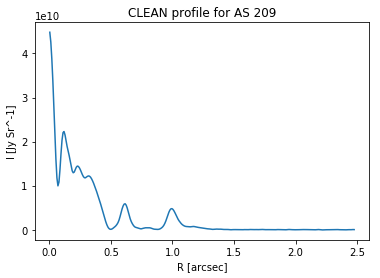

In [5]:
class InterpolatedDSHARPProfile(object):
    """Wrapper for the DSHARP radial profile text files"""
    def __init__(self, data_file, frequency):
        data = np.genfromtxt(data_file, unpack=True)

        r, T = data[1], data[4]

        wave = 299792458.0 / frequency

        I = 2 * 1.3806503e-23 * T  / wave**2
        I *= 1e26

        r /= rad_to_arcsec
            
        self.r = r
        self.Inu = I
 
AS209_profile = InterpolatedDSHARPProfile('AS_209_profile.dat', frequency=239e9)

plt.plot(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu)
plt.xlabel('R [arcsec]')
plt.ylabel('I [Jy Sr^-1]')
plt.title('CLEAN profile for AS 209')

## Next we need to deproject the dataset

Since AS 209 is not face on we need to de-project the disc before we can fit using an axis-symmetric model. We will do that by fitting a gaussian in visibility space.

In [6]:
from frankenstein.geometry import fit_geometry_gaussian, SourceGeometry

fitted_geometry = fit_geometry_gaussian(u,v,vis,weights)

print("Fitted geometry:")
print("\tPA, inclination (deg):\t\t {:.3f} {:.3f}".format(fitted_geometry.PA*180/np.pi, fitted_geometry.inc*180/np.pi))
print("\tPhase centre, dRA, dDec (mas):\t {:.3f} {:3f}".format(1e3*fitted_geometry.dRA, 1e3*fitted_geometry.dDec))


Fitted geometry:
	PA, inclination (deg):		 86.470 -33.933
	Phase centre, dRA, dDec (mas):	 0.863 -0.228760


The fit can also be performed without fitting for the phase centre:

In [7]:
fitted_geometry2 = fit_geometry_gaussian(u,v,vis,weights, phase_centre=(0,0))

print("Fitted geometry:")
print("\tPA, inclination (deg):\t\t {:.3f} {:.3f}".format(fitted_geometry2.PA*180/np.pi, fitted_geometry2.inc*180/np.pi))
print("\tPhase centre, dRA, dDec (mas):\t {:.3f} {:.3f}".format( 1e3*fitted_geometry2.dRA, 1e3*fitted_geometry2.dDec))

Fitted geometry:
	PA, inclination (deg):		 86.464 -33.935
	Phase centre, dRA, dDec (mas):	 0.000 0.000


Since these fitted results agree with the published values, we will use those

Text(0.5,1,'Binned visibilites')

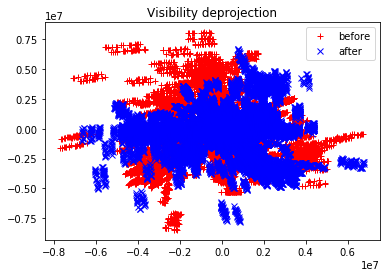

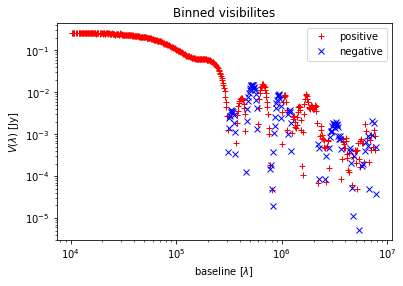

In [8]:
geometry = SourceGeometry(dRA=1.9e-3, dDec=-2.5e-3, inc=34.97*np.pi/180, PA=85.76*np.pi/180)

ub, vb, Vb = geometry.apply_correction(u,v, vis)

#Plot a subset of the uv-points before and after de-projecion:
plt.plot(u[::10],v[::10], 'r+', label='before')
plt.plot(ub[::10],vb[::10], 'bx', label='after')
plt.legend()
plt.title('Visibility deprojection')

# Make a binned version of the de-projected data
uv_bin, vis_bin, w_bin = bin_uv_data(np.hypot(ub,vb), Vb.real, weights)

plt.figure()
plt.loglog(uv_bin, +vis_bin.real, 'r+',label='positive')
plt.loglog(uv_bin, -vis_bin.real, 'bx',label='negative')
plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('$V(\lambda)$ [Jy]')
plt.title('Binned visibilites')


## Now we fit the data

From the radial profile we know that the emission is close to zero beyond 1.6 arcsec, so lets fit to there.

Also use 300 bins, $\alpha=1.05$ and $w_s = 1/\sigma_s^2 = 0.01$

Note that we only fit the real component of the visibilities as an axi-symmetric source has zero imaginary component

In [9]:
from frankenstein import FrankFitter

Rmax = 1.6/rad_to_arcsec

FF = FrankFitter(Rmax, 300, geometry=geometry, alpha=1.05, weights_smooth=1e-2)

best_fit = FF.fit(u, v, vis, weights)

Let's plot the fit in real space and compare to CLEAN.

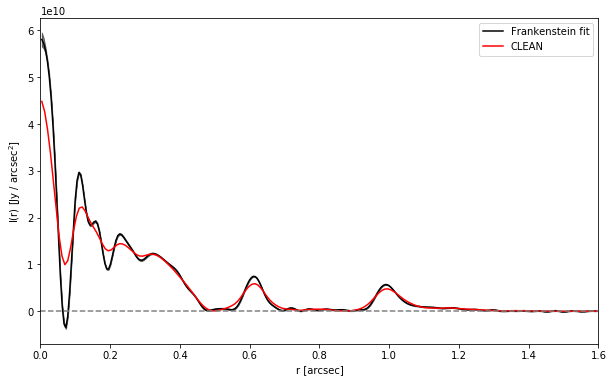

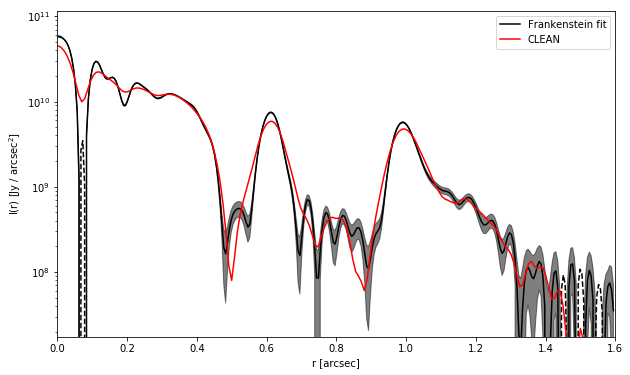

In [10]:
plt.figure(figsize=(10,6))

plt.plot(best_fit.r*rad_to_arcsec, best_fit.mean, 'k', label='Frankenstein fit')

# Plot an estimate of the confidence interval using the covariance matrix
err = np.diag(best_fit.covariance)**0.5
plt.fill_between( best_fit.r*rad_to_arcsec, best_fit.mean-err, best_fit.mean+err, color='k', alpha=0.5)
   
# Plot the CLEAN profile
plt.plot(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, 'r', label='CLEAN')
    
plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.axhline(0, c='0.5', ls='--')
plt.xlim(0, 1.6)
plt.legend()

# Plot in logspace
plt.figure(figsize=(10,6))

plot_log_abs(best_fit.r*rad_to_arcsec, best_fit.mean, c='k', label='Frankenstein fit')
plt.fill_between(best_fit.r*rad_to_arcsec, best_fit.mean-err, best_fit.mean+err, color='k', alpha=0.5)

plot_log_abs(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, c='r', label='CLEAN')

plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.ylim(ymin=3e-4*best_fit.mean.max())
plt.xscale('linear')
plt.xlim(0, 1.6)
plt.legend()

Now let's compare the visibilities. Note the Hankel Transform of the CLEAN profile is low beyond $2\times 10^6 \lambda$ because of beam convolution.

(1e-05, 1.049530344199105)

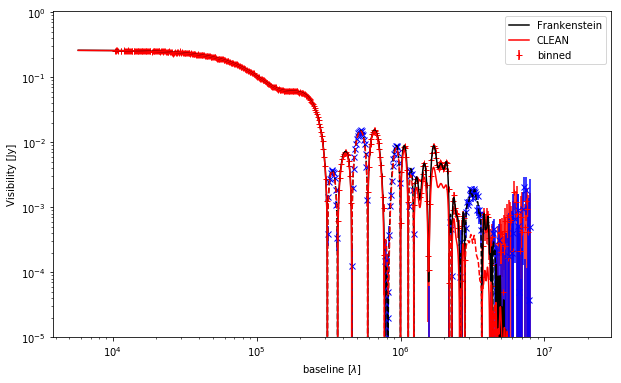

In [11]:
# Plot the visibilies
plt.figure(figsize=(10,6))
l = plt.errorbar(uv_bin, vis_bin, yerr=w_bin**-0.5,marker='+', ls='none', c='r', label='binned', zorder=-1)
plt.errorbar(uv_bin, -vis_bin, yerr=w_bin**-0.5,marker='x', ls='none', c='b', zorder=-1)

uv = np.hypot(u, v)
ki = np.logspace(np.log10(min(uv.min(), best_fit.q[ 0])) - 0.3, 
                 np.log10(max(uv.max(), best_fit.q[-1])) + 0.0,
                 10**4)

plot_log_abs(ki, best_fit.predict_deprojected(ki), c='k', label='Frankenstein')

# Plot also the predicted visibilities of the CLEAN image
from frankenstein.hankel import DiscreteHankelTransform
dht = DiscreteHankelTransform(Rmax,300)
plot_log_abs(ki, 
             best_fit.predict_deprojected(ki, 
                                     I=np.interp(dht.r, 
                                                 AS209_profile.r, 
                                                 AS209_profile.Inu)),
             c='r', label='CLEAN')

plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('Visibility [Jy]')
plt.ylim(ymin=1e-5)